Step 1: Environment Setup

In [179]:
# Assignment 2: Monitoring vegetation patterns
# Google Colab Notebook

# Environment Setup and Authentication

# Cloning fork into Google Colab
#!git clone https://github.com/emgeek-gs/RS_Analyst_Technical_Assignments.git
#%cd /RS_Analyst_Technical_Assignments/vegetation_monitoring
#!pip install earthengine-api geemap pandas numpy matplotlib seaborn xarray

# 1. Import libraries
import os
import ee
import geemap
import rioxarray
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import rasterio
import folium
from IPython.display import display
from matplotlib.dates import DateFormatter
from shapely.geometry import Polygon, mapping
from scipy.stats import gaussian_kde
import matplotlib.dates as mdates

# Configuration
PHENOLOGY_METRICS = ['SOS1', 'Peak1', 'EOS1', 'SOS2', 'Peak2', 'EOS2']
VI_NAMES = ['EVI', 'NDMI', 'MSAVI']
DEFAULT_CRS = 'EPSG:4326'
NO_DATA_VALUE = -9999
OUTPUT_DIR = '/content/drive/MyDrive/NS/outputs_veg/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-enzyoka84')

Step 2: Define Study Area

In [168]:
# Load study area geometry
study_area = geemap.geojson_to_ee('/content/RS_Analyst_Technical_Assignments/vegetation_monitoring/study_area.geojson')

Step 3: Data Acquisition and Preprocessing
Sentinel-2 NDMI, EVI, and MSAVI

In [169]:
# Helper Functions
def mask_clouds(img):
    scl = img.select('SCL')
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))
    return img.updateMask(mask)

def add_indices(img):
    red = img.select('B4').multiply(1e-4)
    nir = img.select('B8').multiply(1e-4)
    blue = img.select('B2').multiply(1e-4)
    swir = img.select('B11').multiply(1e-4)

    ndmi = nir.subtract(swir).divide(nir.add(swir)).rename('NDMI')
    evi = nir.subtract(red).multiply(2.5).divide(
        nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1)
    ).rename('EVI')
    msavi = nir.multiply(2).add(1).subtract(
        (nir.multiply(2).add(1).pow(2).subtract(nir.subtract(red).multiply(8))
         .sqrt()
        )
    ).divide(2).rename('MSAVI')
    return img.addBands([ndmi, evi, msavi])

def make_monthly_composites(start_date, end_date, roi):
    col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterDate(start_date, end_date)
           .filterBounds(roi)
           .map(mask_clouds)
           .map(add_indices))

    start = ee.Date(start_date)
    months = ee.List.sequence(0, ee.Date(end_date).difference(start, 'month').toInt().add(1).subtract(1))

    def make_month(m):
        m = ee.Number(m)
        s = start.advance(m, 'month')
        e = s.advance(1, 'month')
        return col.filterDate(s, e).median() \
                 .reproject(crs=DEFAULT_CRS, scale=100) \
                 .set({'system:time_start': s.millis()})

    return ee.ImageCollection(months.map(make_month))


Step 4: Monthly Composites

In [170]:
# Load & Process
def load_monthly_composites(periods, roi):
    ds_dict = {}
    # Get bounds from study_area.geojson polygon
    gdf = gpd.read_file(f"{OUTPUT_DIR}study_area.geojson")
    minx, miny, maxx, maxy = gdf.total_bounds

    for label, (start, end) in periods.items():
        coll = make_monthly_composites(start, end, roi)
        imgs = coll.toList(coll.size())
        n = imgs.size().getInfo()

        data, times = {vi: [] for vi in VI_NAMES}, []

        for i in range(n):
            img = ee.Image(imgs.get(i))
            date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
            times.append(date)

            # Sample using EE polygon geometry
            props = img.select(VI_NAMES).sampleRectangle(region=roi, defaultValue=NO_DATA_VALUE)
            for vi in VI_NAMES:
                arr = np.array(props.get(vi).getInfo())
                arr[arr == NO_DATA_VALUE] = np.nan
                data[vi].append(arr)

        # Create coordinates from polygon bounds
        height, width = data[VI_NAMES[0]][0].shape
        lon_coords = np.linspace(minx, maxx, width)
        lat_coords = np.linspace(miny, maxy, height)

        ds = xr.Dataset(
            {vi: (('time', 'lat', 'lon'), np.stack(data[vi])) for vi in VI_NAMES},
            coords={
                'time': pd.to_datetime(times),
                'lat': lat_coords,
                'lon': lon_coords
            }
        )
        ds = ds.rio.set_spatial_dims('lon', 'lat')
        ds.rio.write_crs(DEFAULT_CRS, inplace=True)
        ds.to_netcdf(f"{OUTPUT_DIR}indices_{label}.nc")
        ds_dict[label] = ds

    return ds_dict

Step 5: Phenology & Productivity

In [171]:
def extract_phenology(ts_array):
    def get_metrics(ts):
        ts = np.nan_to_num(ts, nan=NO_DATA_VALUE)
        if np.all(ts==NO_DATA_VALUE): return [np.nan]*6
        peaks, props = find_peaks(ts, distance=2, prominence=0.02)
        if len(peaks)==0: return [np.nan]*6
        idx = np.argsort(props['prominences'])[-2:]; top=np.sort(peaks[idx])
        mtrs=[]
        for p in top:
            s=p
            while s>0 and ts[s-1]<ts[s]: s-=1
            e=p
            while e<len(ts)-1 and ts[e+1]<ts[e]: e+=1
            mtrs.extend([s,p,e])
        while len(mtrs)<6: mtrs.append(np.nan)
        return mtrs
    y,x = ts_array.shape[1:]
    res = Parallel(n_jobs=-1)(delayed(get_metrics)(ts_array[:,j,i]) for j in range(y) for i in range(x))
    return np.array(res).reshape((y,x,6))

def calculate_productivity(pheno,evi):
    seasons = pheno.shape[2]//3; prod=np.zeros((seasons,)+pheno.shape[:2])
    for s in range(seasons):
        sos=np.nan_to_num(pheno[:,:,s*3]).astype(int); eos=np.nan_to_num(pheno[:,:,s*3+2]).astype(int)
        for t in range(evi.shape[0]): prod[s][(sos<=t)&(t<=eos)] += evi[t][(sos<=t)&(t<=eos)]
    return prod


Step 6: Export Raster Function

In [172]:
def export_raster(arr, ref_ds, out_path):
    transform = ref_ds.rio.transform()
    crs = ref_ds.rio.crs
    height, width = arr.shape

    with rasterio.open(
        out_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=arr.dtype,
        crs=crs,
        transform=transform,
        nodata=NO_DATA_VALUE
    ) as dst:
        dst.write(arr, 1)


Step 7: Plotting Functions

In [173]:
def plot_combined_time_series(ds_dict):
    for vi in VI_NAMES:
        fig, ax = plt.subplots(figsize=(10,4))
        for label, ds in ds_dict.items():
            ax.plot(ds.time.values, ds[vi].mean(dim=('lat','lon')).values,
                    marker='o', label=f'Period {label}')
        ax.set_title(f'Time Series of {vi}')
        ax.set_xlabel('Date')
        ax.set_ylabel(vi)
        ax.legend()
        ax.grid()
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}timeseries_{vi}.png")
        plt.show()

Step 8:Folium Map Display

In [174]:
def display_folium_maps(ds_dict):
    gdf = gpd.read_file(f"{OUTPUT_DIR}study_area.geojson")
    minx, miny, maxx, maxy = gdf.total_bounds
    center_lat = (miny + maxy) / 2
    center_lon = (minx + maxx) / 2

    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles=None)
    folium.TileLayer(
        tiles='http://mt1.google.com/vt/lyrs=y,h&x={x}&y={y}&z={z}',
        attr='Google Hybrid', name='Satellite Hybrid', overlay=False
    ).add_to(m)

    folium.GeoJson(
        gdf,
        name='Study Area',
        style_function=lambda feat: {'color': 'yellow', 'weight': 2, 'fill': False}
    ).add_to(m)

    # Verify raster existence first
    required_rasters = ['SOS1_A.tif', 'SOS1_diff.tif', 'prod_diff_season1.tif']
    for raster in required_rasters:
        if not os.path.exists(f"{OUTPUT_DIR}{raster}"):
            raise FileNotFoundError(f"Missing required raster: {raster}")

    from matplotlib import cm
    for raster_name in required_rasters:
        path = f"{OUTPUT_DIR}{raster_name}"
        da = rioxarray.open_rasterio(path)
        arr = da.values[0]

        vmin = np.nanpercentile(arr, 2)
        vmax = np.nanpercentile(arr, 98)
        normed = (arr - vmin) / (vmax - vmin)
        normed = np.clip(normed, 0, 1)

        cmap = cm.viridis if 'diff' not in raster_name else cm.coolwarm
        rgba = cmap(normed)

        tmp_png = f"overlay_{raster_name.replace('.tif', '.png')}"
        plt.imsave(tmp_png, rgba, origin='upper')

        folium.raster_layers.ImageOverlay(
            name=raster_name.replace('.tif',''),
            image=tmp_png,
            bounds=[[miny, minx], [maxy, maxx]],
            opacity=0.7
        ).add_to(m)

    folium.LayerControl().add_to(m)
    display(m)


Step 9: Statistics Functions

In [175]:
def compute_statistics(ds_dict, out_csv):
    rows = []
    for vi in VI_NAMES:
        for label, ds in ds_dict.items():
            vals = ds[vi].values.flatten()
            vals = vals[~np.isnan(vals)]
            rows.append({
                'Period': label,
                'Index': vi,
                'Mean': np.mean(vals),
                'Median': np.median(vals),
                'Std': np.std(vals),
                'Q10': np.percentile(vals, 10),
                'Q90': np.percentile(vals, 90)
            })
    pd.DataFrame(rows).to_csv(out_csv, index=False)

def compute_change_summary(ds_dict, out_csv):
    rows = []
    for vi in VI_NAMES:
        arrA = ds_dict['A'][vi].values.flatten()
        arrB = ds_dict['B'][vi].values.flatten()
        arrA = arrA[~np.isnan(arrA)]
        arrB = arrB[~np.isnan(arrB)]
        meanA, meanB = arrA.mean(), arrB.mean()
        medA, medB = np.median(arrA), np.median(arrB)
        rows.append({
            'Index': vi,
            'Mean_A': meanA, 'Mean_B': meanB,
            'Change_Mean': meanB - meanA,
            'Percent_Change_Mean': (meanB - meanA) / meanA * 100 if meanA!=0 else np.nan,
            'Median_A': medA, 'Median_B': medB,
            'Change_Median': medB - medA
        })
    pd.DataFrame(rows).to_csv(out_csv, index=False)

Step 10: Phenology visualization functions

In [176]:
def plot_phenology_timeseries(ds_dict, phA, phB):
    """Plot EVI time series with phenology markers for central pixel"""
    # Get study area bounds
    gdf = gpd.read_file(f"{OUTPUT_DIR}study_area.geojson")
    minx, miny, maxx, maxy = gdf.total_bounds

    # Find center pixel indices
    lat_center = (maxy + miny) / 2
    lon_center = (maxx + minx) / 2

    # Convert to array indices
    lat_idx = np.abs(ds_dict['A'].lat.values - lat_center).argmin()
    lon_idx = np.abs(ds_dict['A'].lon.values - lon_center).argmin()

    # Extract time series
    tsA = ds_dict['A'].EVI.isel(lat=lat_idx, lon=lon_idx)
    tsB = ds_dict['B'].EVI.isel(lat=lat_idx, lon=lon_idx)

    # Get phenology metrics
    phenoA = phA[lat_idx, lon_idx, :]
    phenoB = phB[lat_idx, lon_idx, :]

    plt.figure(figsize=(14, 8))

    # Plot time series
    plt.plot(tsA.time, tsA, label='Period A', color='#1b9e77')
    plt.plot(tsB.time, tsB, label='Period B', color='#7570b3')

    # Plot phenology markers
    def add_markers(ts, pheno, color):
        labels = ['SOS1', 'Peak1', 'EOS1', 'SOS2', 'Peak2', 'EOS2']
        for i, (name, idx) in enumerate(zip(labels, pheno)):
            if not np.isnan(idx) and (0 <= int(idx) < len(ts.time)):
                plt.scatter(ts.time[int(idx)], ts.values[int(idx)],
                           color=color, s=100, zorder=5, marker='X')
                plt.annotate(name,
                           (ts.time[int(idx)], ts.values[int(idx)] + 0.02),
                           color=color, ha='center', fontsize=10)

    add_markers(tsA, phenoA, '#d95f02')
    add_markers(tsB, phenoB, '#e7298a')

    plt.title("EVI Time Series with Phenology Markers\n(Central Pixel)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("EVI", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}evi_phenology_timeseries.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_phenology_subplots(ds_dict, phA, phB):
    """Subplots showing SOS/EOS dates across study area"""
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    fig.suptitle("SOS and EOS Phenology Metrics for Period A (2022/23) and B (2023/24)", fontsize=16)

    subplot_config = [
        ('SOS1', 'A', 0), ('SOS1', 'B', 0),
        ('SOS2', 'A', 3), ('SOS2', 'B', 3),
        ('EOS1', 'A', 2), ('EOS1', 'B', 2),
        ('EOS2', 'A', 5), ('EOS2', 'B', 5),
    ]

    for ax, (metric, period, idx) in zip(axes.flat, subplot_config):
        # Get phenology data
        pheno = phA if period == 'A' else phB
        time_data = ds_dict[period].time.values

        # Convert indices to dates
        date_nums = np.full(pheno[:,:,idx].shape, np.nan)
        valid = ~np.isnan(pheno[:,:,idx])
        indices = pheno[:,:,idx][valid].astype(int)

        try:
            dates = pd.to_datetime(time_data[indices])
            date_nums[valid] = mdates.date2num(dates)
        except IndexError:
            pass

        # Plot with date formatting
        im = ax.imshow(date_nums, cmap='viridis')
        ax.set_title(f"{metric} - {period}")

        # Colorbar with date formatting
        if np.any(valid):
            cbar = plt.colorbar(im, ax=ax, format=mdates.DateFormatter('%d.%m'))
            cbar.set_label("Date (dd.mm)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{OUTPUT_DIR}phenology_subplots.png", dpi=300)
    plt.show()

Step 11: Main Execution

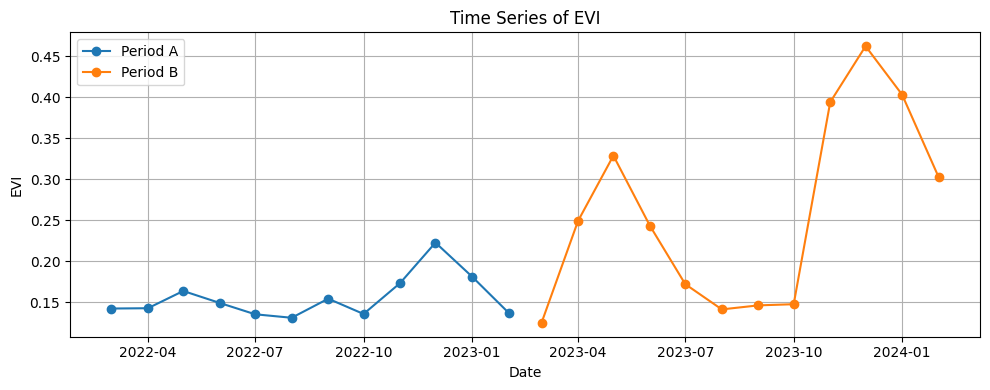

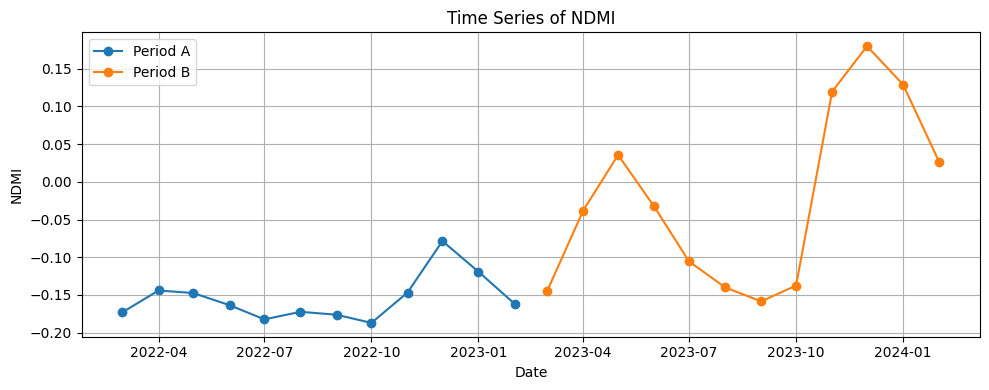

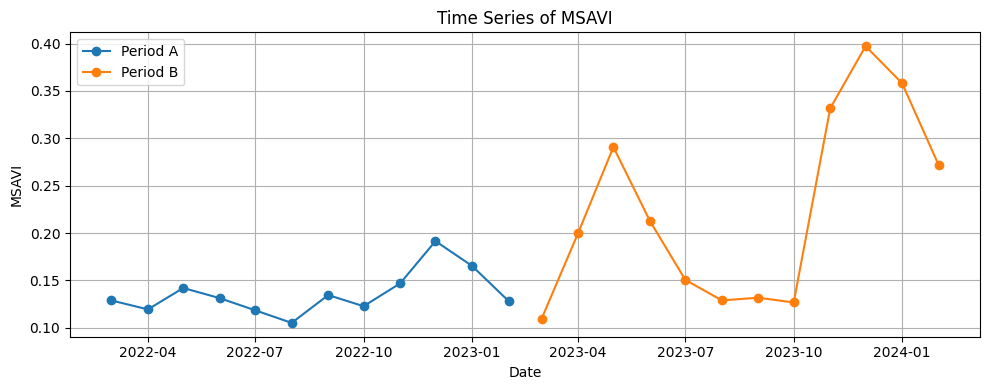

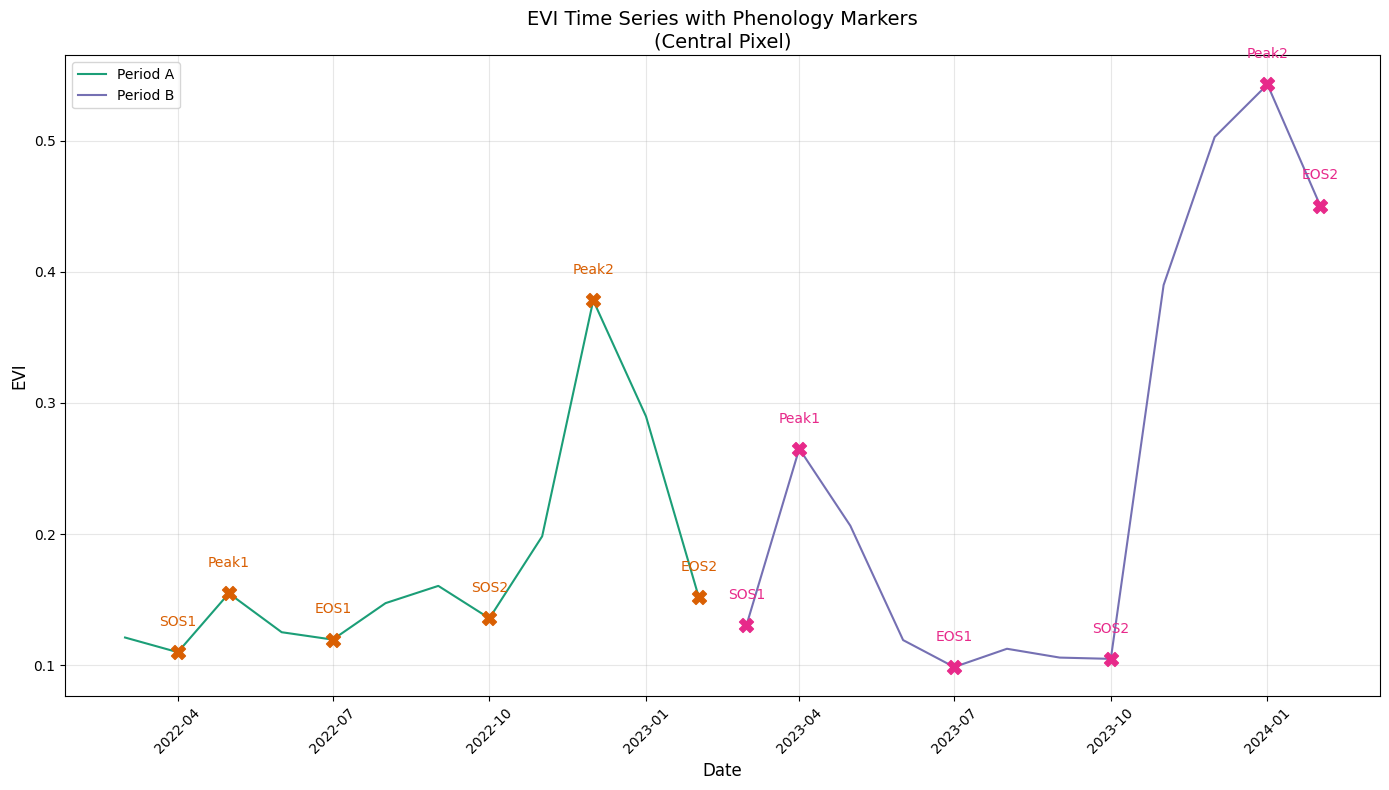

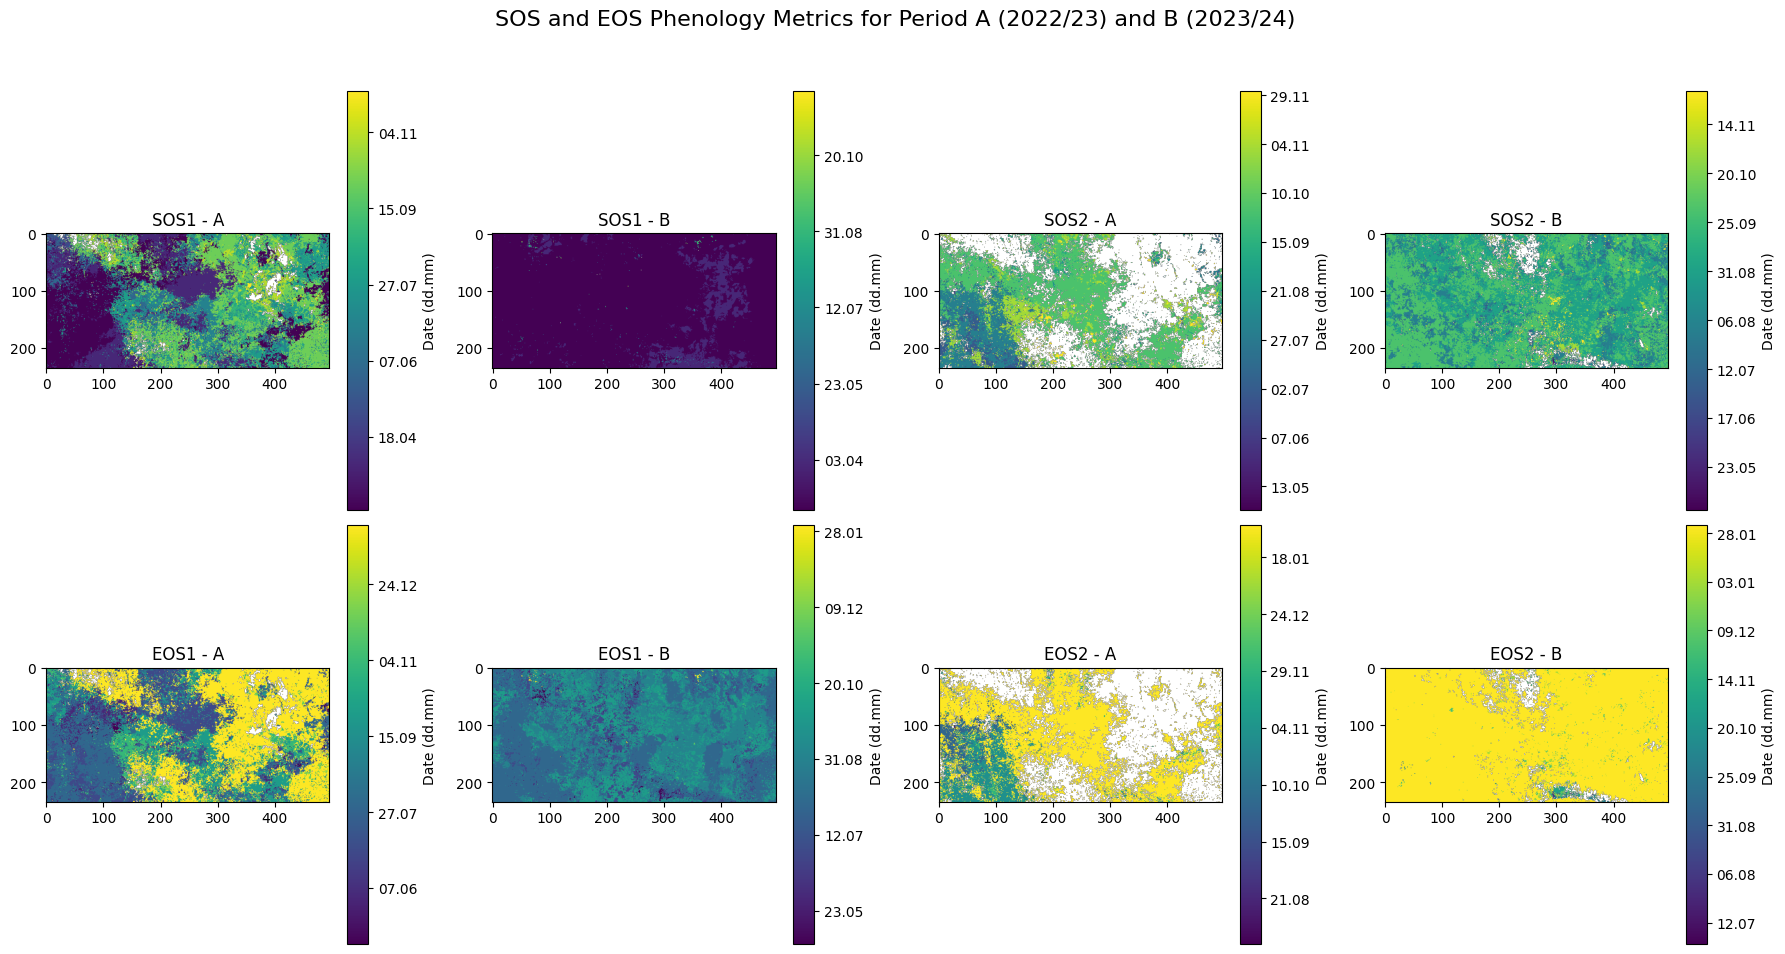


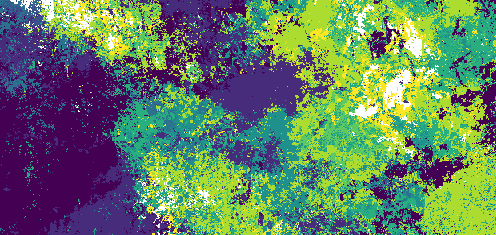
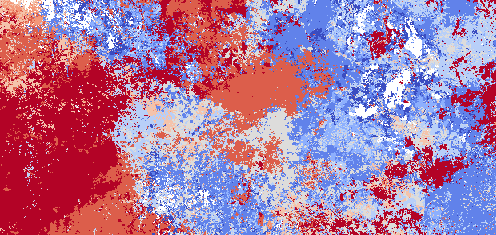
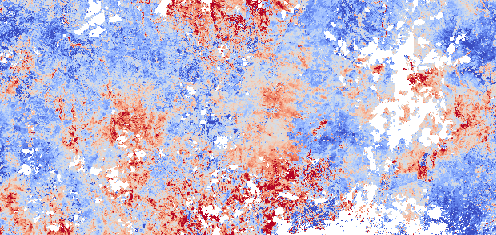

Processing complete. Check output directory for results.


In [180]:
if __name__ == '__main__':
    # Load study area polygon from GeoJSON
    gdf = gpd.read_file(f"{OUTPUT_DIR}study_area.geojson")

    # Convert to EE Polygon with proper nesting
    polygon_geojson = mapping(gdf.geometry[0])
    roi = ee.Geometry.Polygon(polygon_geojson['coordinates'])

    # Process periods
    PERIODS = {'A': ('2022-03-01', '2023-02-28'), 'B': ('2023-03-01', '2024-02-29')}
    ds = load_monthly_composites(PERIODS, roi)

    # Generate plots
    plot_combined_time_series(ds)


    # Calculate phenology metrics
    phA = extract_phenology(ds['A'].EVI.values)
    phB = extract_phenology(ds['B'].EVI.values)
    pA = calculate_productivity(phA, ds['A'].EVI.values)
    pB = calculate_productivity(phB, ds['B'].EVI.values)

    plot_phenology_timeseries(ds, phA, phB)
    plot_phenology_subplots(ds, phA, phB)

    # Export corrected rasters
    export_raster(phA[:,:,0], ds['A'], f"{OUTPUT_DIR}SOS1_A.tif")
    export_raster(phB[:,:,0] - phA[:,:,0], ds['A'], f"{OUTPUT_DIR}SOS1_diff.tif")  # Correct difference
    export_raster(pB[0] - pA[0], ds['A'], f"{OUTPUT_DIR}prod_diff_season1.tif")

    # Generate reports
    compute_statistics(ds, f"{OUTPUT_DIR}vi_stats.csv")
    compute_change_summary(ds, f"{OUTPUT_DIR}season_changes.csv")

    # Final display
    display_folium_maps(ds)
    print('Processing complete. Check output directory for results.')